In [1]:
from _utils import *

2024-10-30 16:29:03.692201: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 16:29:03.739494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_dir = '/mnt/home/tudomlumleart/ceph/16_EmbryoDataset/E10p5_datasets'
dna_xy_path = os.path.join(dataset_dir, 'dna_aligned_XY.csv')
dna_trace_path = os.path.join(dataset_dir, 'E10p5_DNA.mat')
rna_spot_path = os.path.join(dataset_dir, 'rnaSpots.csv')

In [4]:
dna_xy = pd.read_csv(dna_xy_path)
rna_spot = pd.read_csv(rna_spot_path)

In [10]:
with h5py.File(dna_trace_path, 'r') as file:
    # List all datasets in the file
    print("Keys: ", list(file.keys()))
    
    dna_maps = file['maps'][:]
    dna_polys = file['polys'][:]

Keys:  ['maps', 'polys']


In [13]:
dna_xy.shape

(87693, 2)

In [12]:
dna_maps.shape, dna_polys.shape

((87693, 66, 66), (87693, 3, 66))

In [14]:
# Perform k-means clustering on the xy data
from sklearn.cluster import KMeans


In [15]:
n_clusters = 10
# Create a KMeans instance with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(dna_xy)

# Get the cluster centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [84]:
# Save this cluster assignment for later use
kmeans_assignment = pd.DataFrame({'x': dna_xy['x'], 'y': dna_xy['y'], 'cluster': labels})
kmeans_assignment.to_csv(os.path.join(dataset_dir, '20241030_kmeans_assignment.csv'), index=False)

In [22]:
dna_xy

,x,y
0,13157.877115,22613.176266
1,12898.923144,22574.383986
2,14163.816428,22335.338006
3,12928.487712,22532.935991
4,12854.999435,22530.025135
...,...,...
87688,18195.603901,9467.969961
87689,17756.702808,9535.333385
87690,18798.703546,9345.753686
87691,19459.506899,9223.006268


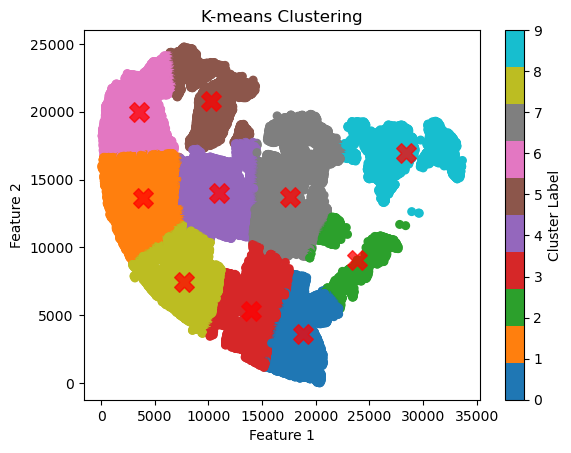

In [32]:
# Plotting the clusters and centroids
scatter = plt.scatter(dna_xy.iloc[:, 0], dna_xy.iloc[:, 1], c=labels, s=30, cmap='tab10')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Create a color bar
cbar = plt.colorbar(scatter, ticks=range(n_clusters))  # Adjust ticks to match the number of clusters
cbar.set_label('Cluster Label')
cbar.set_ticks(np.arange(n_clusters))  # Labels for each cluster

plt.show()


In [33]:
# Iterate through the clusters and extract distance maps from that cluster
unique_labels = np.unique(labels)
cluster_maps = []
cluster_polys = []
for label in unique_labels:
    cluster_indices = np.where(labels == label)[0]
    cluster_maps.append(dna_maps[cluster_indices])
    cluster_polys.append(dna_polys[cluster_indices])

In [26]:
# Find the median maps in different clusters 
median_maps = [np.nanmedian(cluster, axis=0) for cluster in cluster_maps]

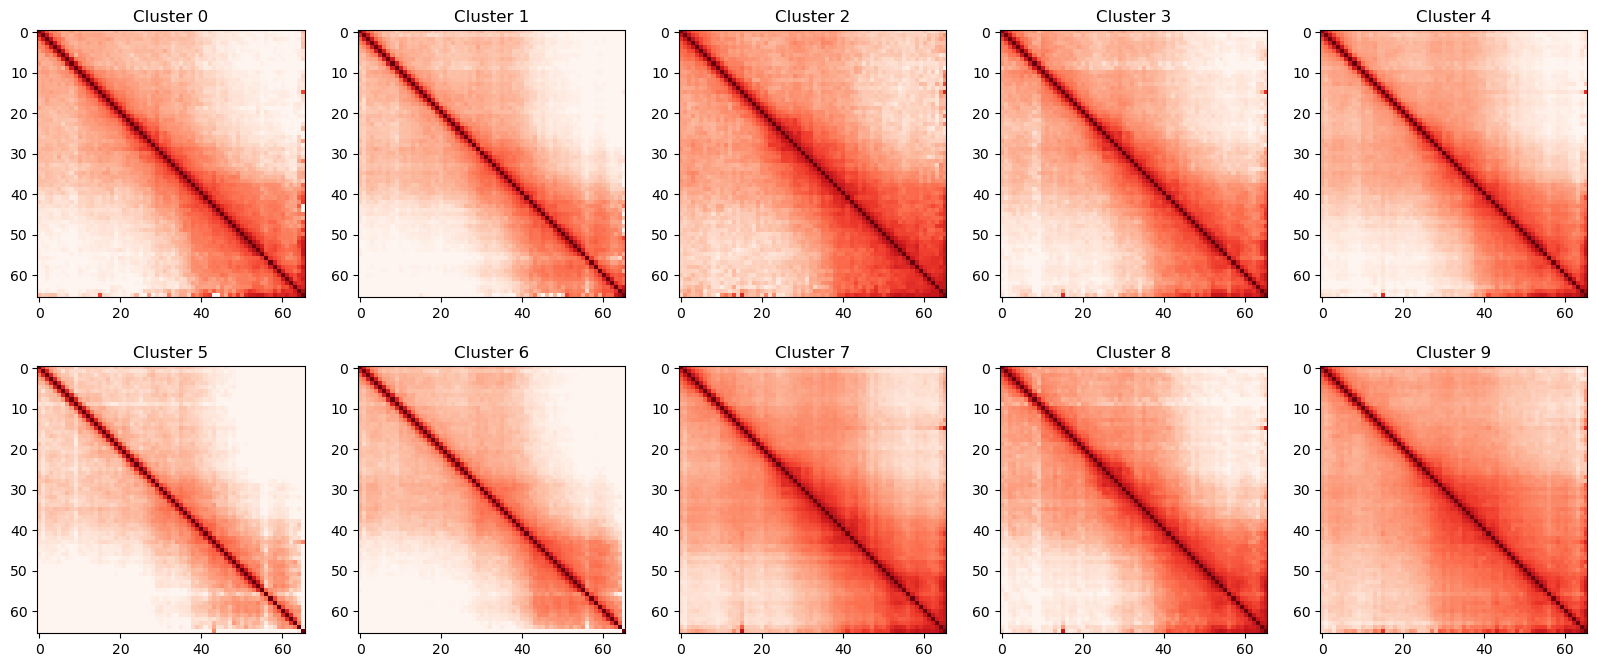

In [113]:
# Plot all median maps 
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(median_maps[i], cmap='Reds_r', vmax=400)
    ax.set_title(f'Cluster {i}')

In [37]:
# Interpolate the DNA polys 
cluster_polys_interp = []
for cluster in cluster_polys:
    # transpose clusters such that the number of cells is the third dimension
    cluster = np.transpose(cluster, (2, 1, 0))
    print(cluster.shape)
    cluster_polys_interp.append(interpolate_polymers(cluster))

(66, 3, 11894)
(66, 3, 8310)
(66, 3, 4406)
(66, 3, 9909)
(66, 3, 8493)
(66, 3, 6117)
(66, 3, 8363)
(66, 3, 11946)
(66, 3, 10650)
(66, 3, 7605)


In [42]:
cluster_maps_interp = []
cluster_maps_interp_flat = []
for cluster in cluster_polys_interp:
    map_interp = calculate_distance_map(cluster)
    cluster_maps_interp.append(map_interp)
    cluster_maps_interp_flat.append([x.flatten() for x in map_interp])
    

In [43]:
all_maps_interp_flat = np.concatenate(cluster_maps_interp_flat, axis=0)

In [44]:
all_maps_interp_flat.shape

(87693, 4356)

In [45]:
pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
cluster_pca = []
for cluster in cluster_maps_interp_flat:
    cluster_pca.append(pca.transform(cluster))

In [47]:
cluster_pca_list = []
for i, cluster in enumerate(cluster_pca):
    cluster_pca_df = pd.DataFrame(cluster, columns=['PC1', 'PC2'])
    cluster_pca_df['cluster'] = i
    cluster_pca_list.append(cluster_pca_df)
cluster_pca_df_all = pd.concat(cluster_pca_list)

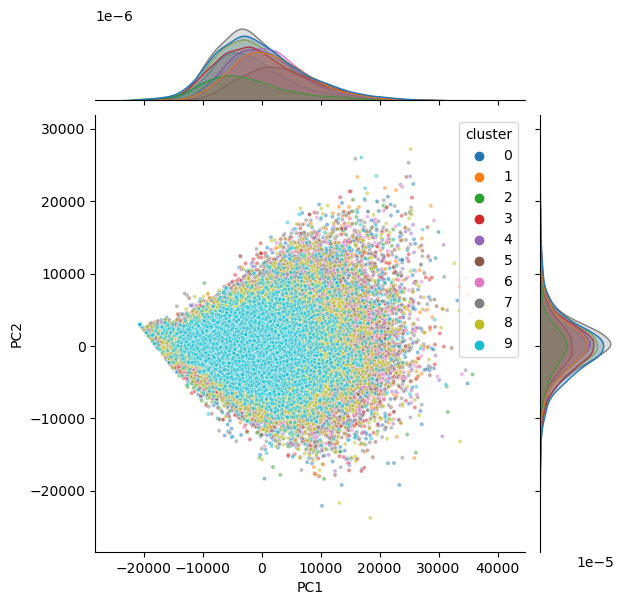

In [50]:
sns.jointplot(data=cluster_pca_df_all, x='PC1', y='PC2', hue='cluster', palette='tab10', alpha=0.5, marker='.')

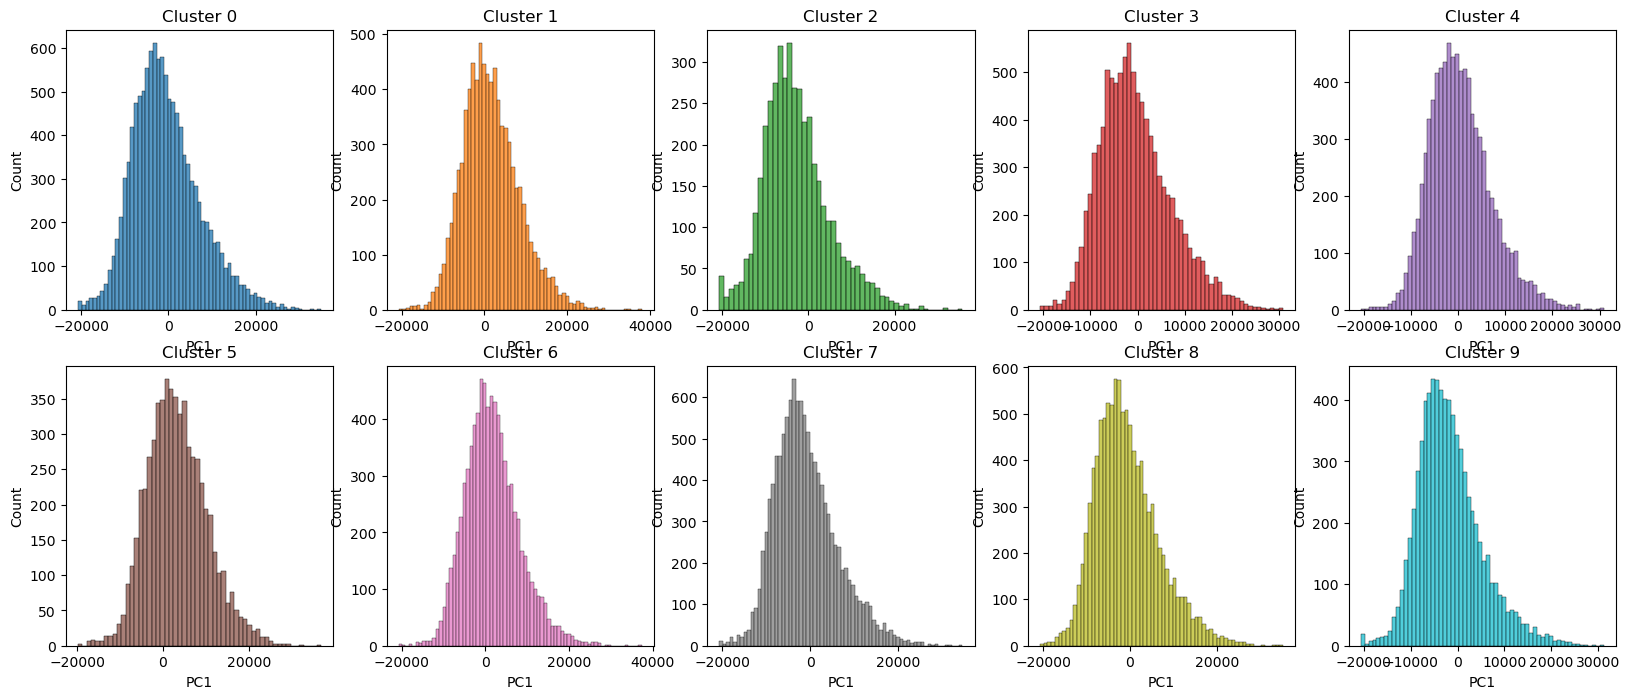

In [51]:
# Plot histogram of the first principal component from all clusters
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flat):
    sns.histplot(cluster_pca_df_all[cluster_pca_df_all['cluster'] == i]['PC1'], ax=ax, color=f'C{i}')
    ax.set_title(f'Cluster {i}')


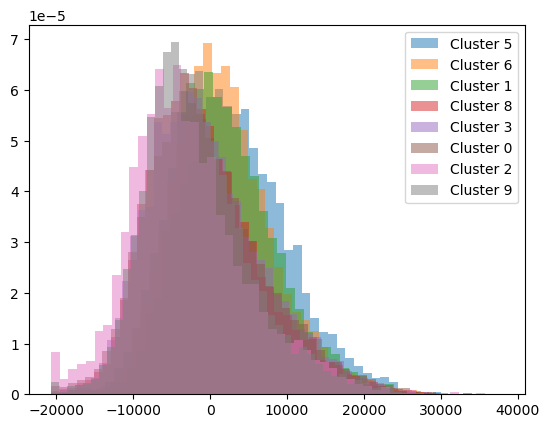

In [54]:
order_list = [5, 6, 1, 8, 3, 0, 2, 9]
for i in order_list:
    plt.hist(cluster_pca_df_all[cluster_pca_df_all['cluster'] == i]['PC1'], bins=50, alpha=0.5, label=f'Cluster {i}', density=True)
plt.legend()

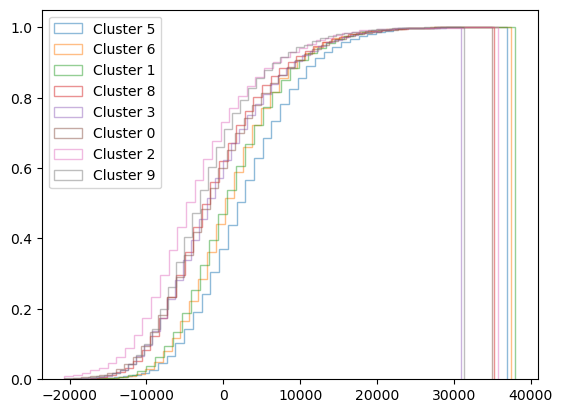

In [55]:
order_list = [5, 6, 1, 8, 3, 0, 2, 9]
for i in order_list:
    # Plot the CDF 
    plt.hist(cluster_pca_df_all[cluster_pca_df_all['cluster'] == i]['PC1'], bins=50, alpha=0.5, label=f'Cluster {i}', density=True, cumulative=True, histtype='step')
plt.legend()


In [71]:
min_pc1 = cluster_pca_df_all['PC1'].min()
max_pc1 = cluster_pca_df_all['PC1'].max()
min_pc2 = cluster_pca_df_all['PC2'].min()
max_pc2 = cluster_pca_df_all['PC2'].max()

num_microstates_per_axis = 30

microstates = generate_microstates(min_pc1, max_pc1, min_pc2, max_pc2,
                                   num_microstates_per_axis, pca)

KeyboardInterrupt: 

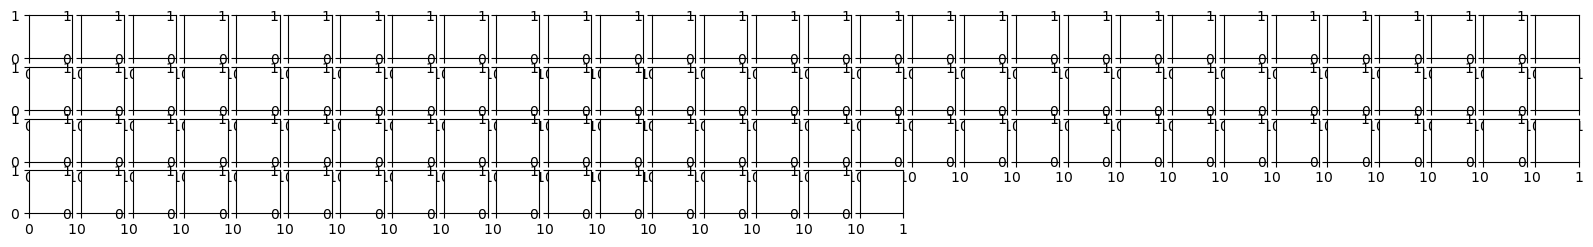

In [72]:
# Plot all the microstates 
fig, axs = plt.subplots(num_microstates_per_axis, num_microstates_per_axis, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    ax.imshow(microstates[i].reshape(66, 66), cmap='Reds_r')
    ax.axis('off')
    ax.set_title(f'Microstate {i}')

In [73]:
microstates_jax = jnp.array(microstates)
cluster_stds_list = []
for cluster in tqdm(cluster_maps_interp):
    cluster_stds_list.append(batch_calculate_variances(jnp.array(cluster), microstates_jax, 66)**0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

In [74]:
lpm = [(logprior(x, 66)).tolist() for x in microstates] 

In [75]:
cluster_stds_list = np.array(cluster_stds_list)
cluster_lls_list = []
for i, cluster in tqdm(enumerate(cluster_maps_interp_flat)):
    cluster = jnp.array(cluster)
    cluster_lls_list.append([compute_loglikelihood_for_y(y, microstates_jax, cluster_stds_list[i], 66) for y in tqdm(cluster)] )

0it [00:00, ?it/s]

  0%|          | 0/11894 [00:00<?, ?it/s]

  0%|          | 0/8310 [00:00<?, ?it/s]

  0%|          | 0/4406 [00:00<?, ?it/s]

  0%|          | 0/9909 [00:00<?, ?it/s]

  0%|          | 0/8493 [00:00<?, ?it/s]

  0%|          | 0/6117 [00:00<?, ?it/s]

  0%|          | 0/8363 [00:00<?, ?it/s]

  0%|          | 0/11946 [00:00<?, ?it/s]

  0%|          | 0/10650 [00:00<?, ?it/s]

  0%|          | 0/7605 [00:00<?, ?it/s]

In [77]:
cluster_lls_tolist_list = []
for cluster in tqdm(cluster_lls_list):
    cluster_lls_tolist_list.append([x.tolist() for x in cluster])

  0%|          | 0/10 [00:00<?, ?it/s]

In [78]:
cluster_maps_interp[0].shape

(11894, 66, 66)

In [79]:
cluster_number_list = []
for cluster in cluster_maps_interp:
    cluster_number_list.append(cluster.shape[0])

In [81]:
M = num_microstates_per_axis ** 2

In [83]:
my_model = CmdStanModel(
    stan_file='/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/stan/20240715_WeightOptimization.stan',
    cpp_options = {
        "STAN_THREADS": True,
    }
    )

n_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {n_cores}")
parallel_chains = 4
threads_per_chain = int(n_cores / parallel_chains)
print(f"Number of threads per chain: {threads_per_chain}")

Number of CPU cores: 64
Number of threads per chain: 16


In [85]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241030_RunWeightMCMC_Embryo_Tutorial_10clusters'
for condition in tqdm(range(n_clusters)):
    condition_name = f'cluster_{condition}'
    output_dir = os.path.join(save_dir, condition_name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    json_filename = os.path.join(output_dir, 'data.json')
    stan_putput_file = os.path.join(output_dir, 'stan_output')
    
    data_dict = {
        'N': cluster_number_list[condition],
        'M': M,
        'll_map': cluster_lls_tolist_list[condition],
        'lpm_vec': lpm
    }
    
    json_obj = json.dumps(data_dict, indent=4)
    
    with open(json_filename, 'w') as json_file:
        json_file.write(json_obj)
        json_file.close()
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [86]:
slurm_file = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/scripts/slurm/2024_RunPythonScript.sh'

In [87]:
submit_mcmc_slurm(save_dir, slurm_file)

Submitting slurm job for cluster_0
Submitting slurm job for cluster_1
Submitted batch job 4103891
Submitted batch job 4103892
Submitting slurm job for cluster_9
Submitted batch job 4103893
Submitting slurm job for cluster_7
Submitting slurm job for cluster_8
Submitted batch job 4103894
Submitted batch job 4103895
Submitting slurm job for cluster_3
Submitted batch job 4103896
Submitting slurm job for cluster_2
Submitted batch job 4103897
Submitting slurm job for cluster_4
Submitted batch job 4103898
Submitting slurm job for cluster_5
Submitted batch job 4103899
Submitting slurm job for cluster_6
Submitted batch job 4103900


In [89]:
mcmc_common_dir = save_dir 

# Find all the folders in the MCMC result directory with 'Kmedoid' in the name
mcmc_folders = [f for f in os.listdir(mcmc_common_dir) if 'cluster' in f]

# Get the full path to each of the folders
mcmc_folders = [os.path.join(mcmc_common_dir, f) for f in mcmc_folders]

num_microstates = 30**2

# Sort based on the number in the filename 
# Number is in the last part after the last underscore
mcmc_folders.sort(key=lambda x: int(x.split('_')[-1]))

# Extract the number of clusters from the folder names
cluster_id = [int(f.split('_')[-1]) for f in mcmc_folders]


In [93]:
mcmc_folders

['/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241030_RunWeightMCMC_Embryo_Tutorial_10clusters/cluster_0',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241030_RunWeightMCMC_Embryo_Tutorial_10clusters/cluster_1',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241030_RunWeightMCMC_Embryo_Tutorial_10clusters/cluster_2',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241030_RunWeightMCMC_Embryo_Tutorial_10clusters/cluster_3',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241030_RunWeightMCMC_Embryo_Tutorial_10clusters/cluster_4',
 '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20241030_RunWeightMCMC_Embryo_Tutorial_10clusters/cluster_5'

In [95]:
mcmc_results = load_mcmc_results(save_dir, num_microstates)

  0%|          | 0/10 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241030193938_1.csv', '20240715_WeightOptimization-20241030193938_2.csv', '20240715_WeightOptimization-20241030193938_3.csv', '20240715_WeightOptimization-20241030193938_4.csv']
['20240715_WeightOptimization-20241030193939_1.csv', '20240715_WeightOptimization-20241030193939_2.csv', '20240715_WeightOptimization-20241030193939_3.csv', '20240715_WeightOptimization-20241030193939_4.csv']
['20240715_WeightOptimization-20241030193938_1.csv', '20240715_WeightOptimization-20241030193938_2.csv', '20240715_WeightOptimization-20241030193938_3.csv', '20240715_WeightOptimization-20241030193938_4.csv']
['20240715_WeightOptimization-20241030193938_1.csv', '20240715_WeightOptimization-20241030193938_2.csv', '20240715_WeightOptimization-20241030193938_3.csv', '20240715_WeightOptimization-20241030193938_4.csv']
['20240715_WeightOptimization-20241030193938_1.csv', '20240715_WeightOptimization-20241030193938_2.csv', '20240715_WeightOptimization-20241030193938_3.csv', '202407

In [96]:
mcmc_results.keys()

dict_keys(['cluster_0', 'cluster_1', 'cluster_9', 'cluster_7', 'cluster_8', 'cluster_3', 'cluster_2', 'cluster_4', 'cluster_5', 'cluster_6'])

In [97]:
mcmc_weights = []
entropy_dfs = [] 
order_list = [5, 6, 1, 8, 3, 0, 2, 9]

for o in tqdm(order_list):
    curr_sample = mcmc_results[f'cluster_{o}']
    
    weights = np.exp(np.array(curr_sample))
    weights = weights.reshape(-1, 30**2)
    
    mcmc_weights.append(weights)
    
    entropy_all = calculate_entropy(weights)
    
    entropy_df = pd.DataFrame(entropy_all, columns=['entropy'])
    entropy_df['cluster'] = o
    
    entropy_dfs.append(entropy_df)

<Axes: xlabel='cluster', ylabel='entropy'>

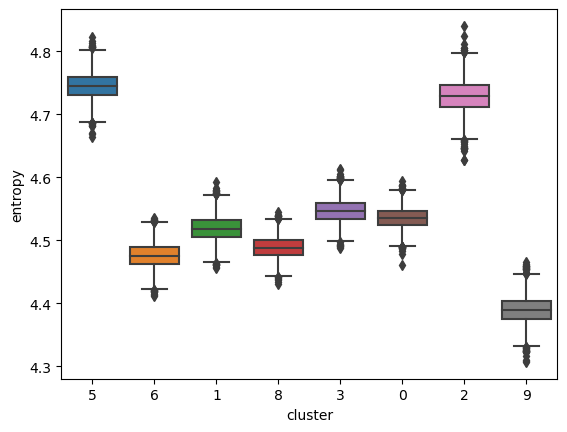

In [99]:
# reorder the boxplot such that the clusters are in the same order as the order_list
entropy_df_all = pd.concat(entropy_dfs)
sns.boxplot(data=entropy_df_all, x='cluster', y='entropy', order=order_list)

In [100]:
mcmc_weights[0].shape

(4000, 900)

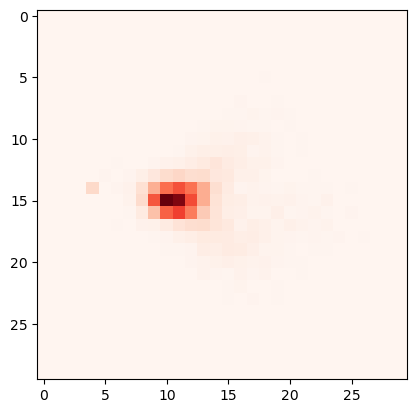

In [102]:
plt.imshow(np.mean(mcmc_weights[0], axis=0).reshape(30, 30).T, cmap='Reds')

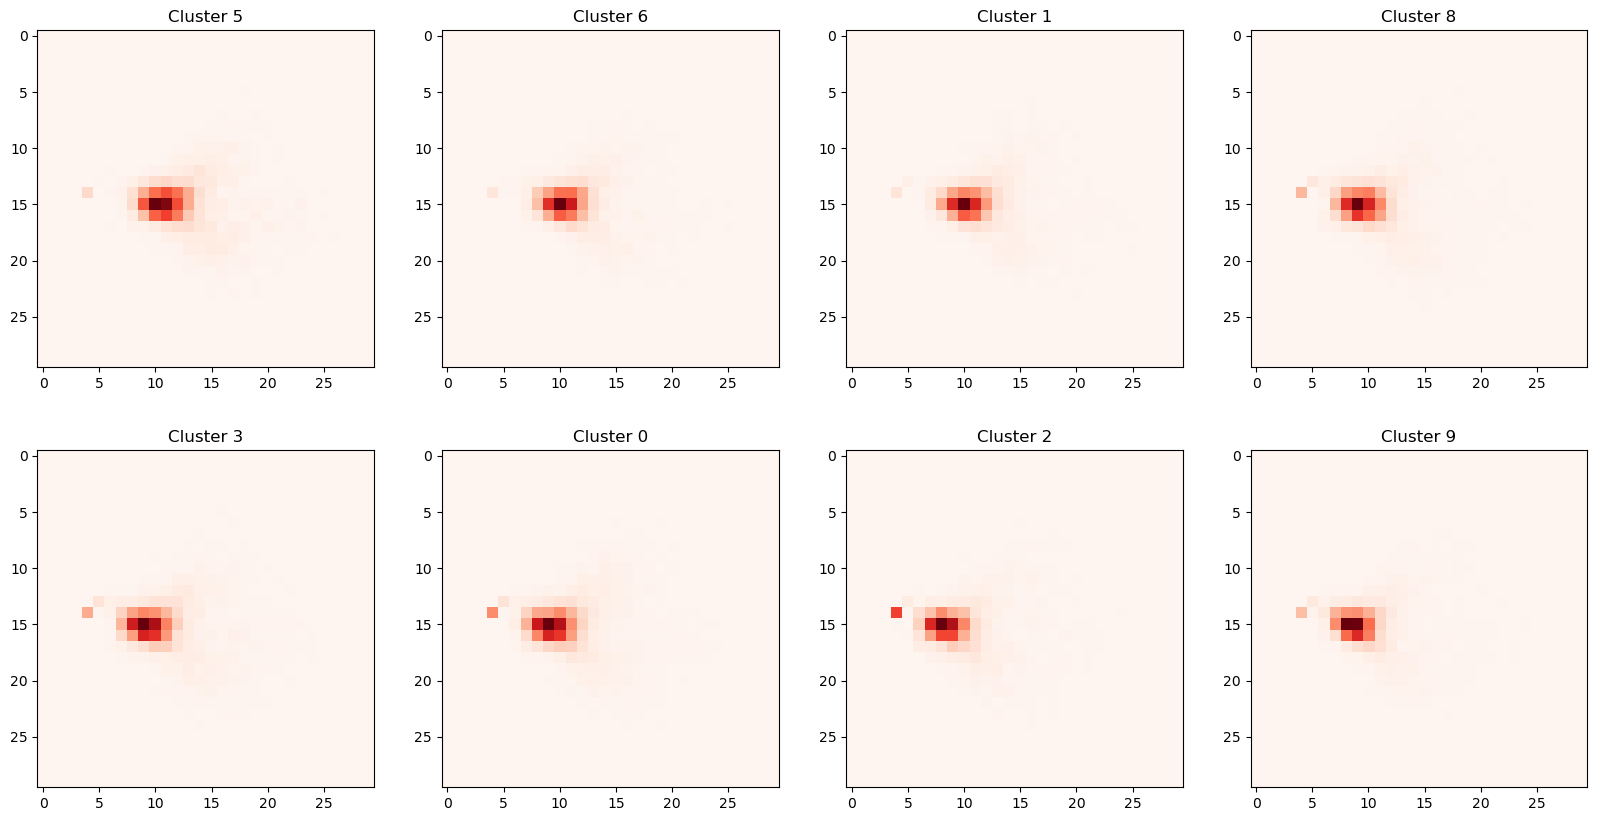

In [104]:
# Plot weights from all clusters
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(np.mean(mcmc_weights[i], axis=0).reshape(30, 30).T, cmap='Reds')
    ax.set_title(f'Cluster {order_list[i]}')

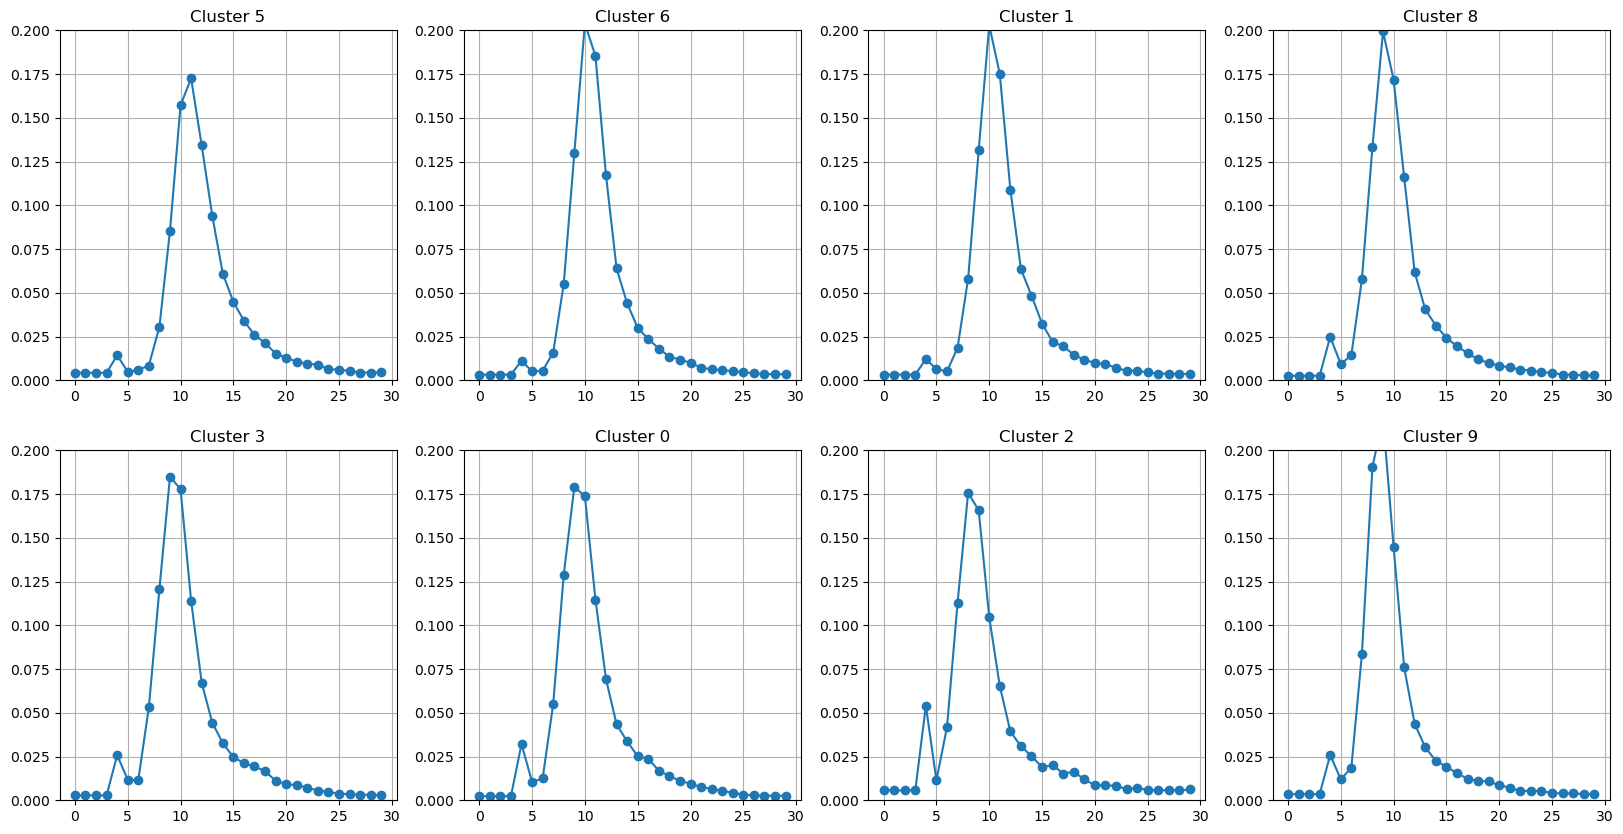

In [111]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    pc1_weights = np.sum(np.mean(mcmc_weights[i], axis=0).reshape(30, 30).T, axis=0)
    norm_pc1_weights = pc1_weights / np.sum(pc1_weights)
    ax.plot(norm_pc1_weights, 'o-')
    ax.set_title(f'Cluster {order_list[i]}')
    ax.set_ylim([0, 0.2])
    ax.grid()

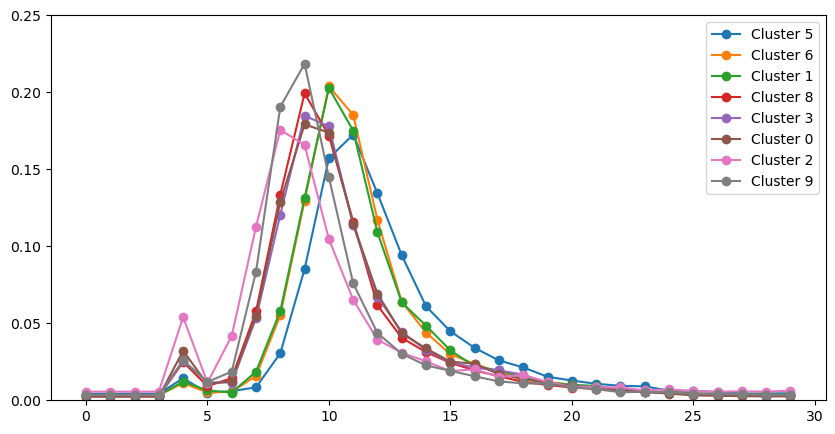

In [112]:
# Plot all the weights in a single plot
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(8):
    pc1_weights = np.sum(np.mean(mcmc_weights[i], axis=0).reshape(30, 30).T, axis=0)
    norm_pc1_weights = pc1_weights / np.sum(pc1_weights)
    ax.plot(norm_pc1_weights, 'o-', label=f'Cluster {order_list[i]}')
ax.set_ylim([0, 0.25])
ax.legend()